The dataset represents Beijing's PM 2.5 Index dataset, which includes 43824 observations and 12 attributes. 

Beijing’s air pollution poses a big threat to the health of local residents. The PM 2.5 Index has been known as an important indication of the air quality. Exploring an effective way of predicting PM 2.5 Index will be an important step towards addressing the pollution. However, various factors such as dew point, temperature, pressure, etc. may influence PM 2.5 and the relationships between them remain unclear.Thus, it is challenging to accurately predict PM 2.5.

The problem that's being investigated here is evaluating the attributes that contribute to PM2.5 in Beijing.To address this problem, Linear Mixed Effects Model is adopted to predict the response variable (ie. air quality) based on the numerous explanatory variables (meteorological records).

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
No       43824 non-null int64
year     43824 non-null int64
month    43824 non-null int64
day      43824 non-null int64
hour     43824 non-null int64
pm2.5    41757 non-null float64
DEWP     43824 non-null int64
TEMP     43824 non-null float64
PRES     43824 non-null float64
cbwd     43824 non-null object
Iws      43824 non-null float64
Is       43824 non-null int64
Ir       43824 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Now for a quick representation of the dataset.

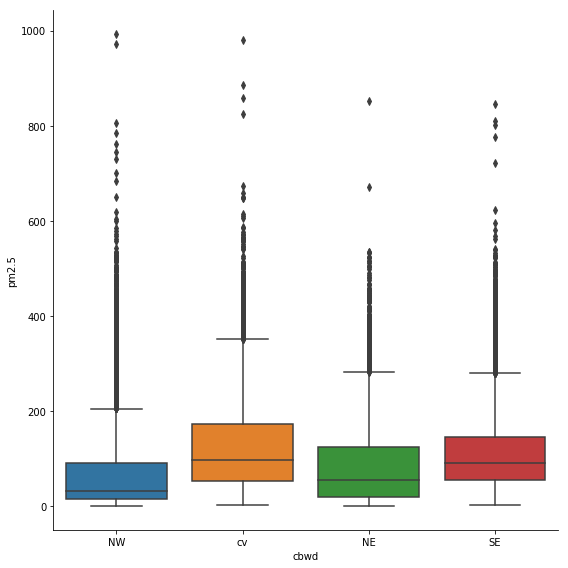

In [3]:
sns.catplot(x='cbwd' , y='pm2.5' , data=data , kind='box' , height = 8)

It's evident that the data is seriously left-skewed, so the dependant varaible should be transformed to produce a normal curve. A Box-Cox plot does a good job of suggetsing the type of transformation required for the dependant variable.

Before that it's good to check for unreasonable data in the dataset.

In [4]:
data.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


It pretty clear that the data has a quite a lot of unreasoable data in it, like, negative PM2.5 values (A negative concentrations can never really exist because the atmosphere cannot have a negative amount of PM) & NULL values. The model would run better if they are removed. 

In [5]:
data = data[data['pm2.5'] > 0]
data.dropna()
print data.head()
print data.describe()

    No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  Is  Ir
24  25  2010      1    2     0  129.0   -16  -4.0  1020.0   SE  1.79   0   0
25  26  2010      1    2     1  148.0   -15  -4.0  1020.0   SE  2.68   0   0
26  27  2010      1    2     2  159.0   -11  -5.0  1021.0   SE  3.57   0   0
27  28  2010      1    2     3  181.0    -7  -5.0  1022.0   SE  5.36   1   0
28  29  2010      1    2     4  138.0    -7  -5.0  1022.0   SE  6.25   2   0
                 No          year         month           day          hour  \
count  41755.000000  41755.000000  41755.000000  41755.000000  41755.000000   
mean   22279.295893   2012.042773      6.513639     15.684924     11.502263   
std    12658.465723      1.415344      3.454239      8.785336      6.924989   
min       25.000000   2010.000000      1.000000      1.000000      0.000000   
25%    11456.500000   2011.000000      4.000000      8.000000      5.000000   
50%    22434.000000   2012.000000      7.000000     16.000000   

Now that the dataset looks all cleaned up, it's about time that we normalized the dependant variable with the help of a Box-cox plot.

The lambda for transformation is 0.16


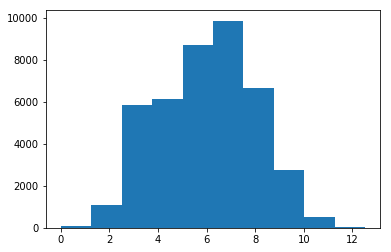

In [6]:
from scipy import stats

suggestion , fitted_lambda = stats.boxcox(data['pm2.5'])

plt.hist(suggestion)

print 'The lambda for transformation is %.2f' %fitted_lambda

Since the lambda is pretty close to 0  , log(x) transform is a potential method to transform the dependant variable.

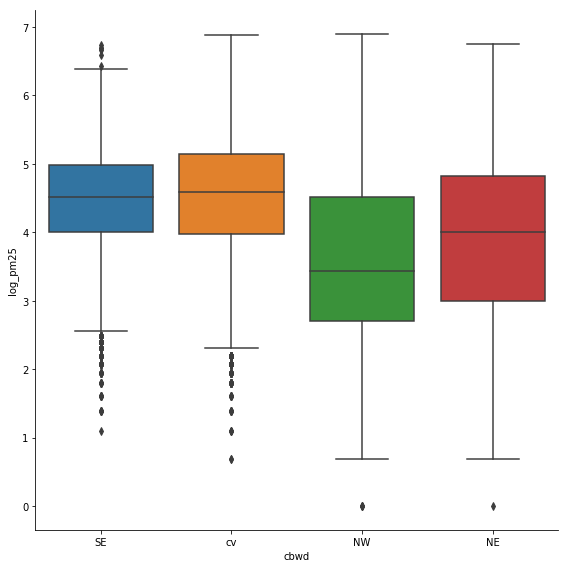

In [7]:
data['log_pm25'] = np.log(data['pm2.5'])

sns.catplot(x='cbwd' , y='log_pm25' , data=data , kind ='box' , height=8)

It's evident that each of the catagories of the cbwd has their own set of outliers, which needs to elimited to get a better working model.

In [8]:
#Splitting the dataset with respect with respect to each of the catagory in cbwd

dfs = ('df_NW','df_cv','df_NE','df_SE')
df_seperate = {}
winds = data['cbwd'].unique()

for df, wind in zip(dfs,winds):
    df_seperate[df] = (DataFrame(data[data['cbwd'] == wind])).sort_values(by=['log_pm25'])

#Setting upper & lower limits for the outliers of each of the catagorized dataframe's log_pm2.5 values
index = np.arange(4)

q1 = [None]*len(index)
q3 = [None]*len(index)
iqr= [None]*len(index)
upper_limit = [None]*len(index)
lower_limit = [None]*len(index)

for df, i in zip(dfs,index):
    q1[i],q3[i]= np.percentile(df_seperate[df]['log_pm25'],[25,75])
    iqr[i] = q3[i] - q1[i]
    upper_limit[i] = q1[i] + (1.5 * iqr[i])
    lower_limit[i] = q1[i] - (1.5 * iqr[i])

#DataFrame of outlier limits for each of the catagorized dataframes 
Outlier_limit = DataFrame(zip(q1,q3,iqr,upper_limit,lower_limit),index=[np.transpose(dfs)],
                          columns=['Q1','Q3','IQR','Upper_limit','Lower_limit'])

Outlier_limit

,Q1,Q3,IQR,Upper_limit,Lower_limit
df_NW,4.007333,4.976734,0.969401,5.461434,2.553232
df_cv,3.970292,5.148944,1.178652,5.738270,2.202314
df_NE,2.708050,4.510860,1.802809,5.412264,0.003836
df_SE,2.995732,4.828314,1.832581,5.744604,0.246860


In [9]:
# Outliers removed
for df,i in zip(dfs,index):
    df_seperate[df] = df_seperate[df][(df_seperate[df]['log_pm25'] < Outlier_limit['Upper_limit'][i]) &
                                      (df_seperate[df]['log_pm25'] > Outlier_limit['Lower_limit'][i])]

#New_dataframe with all the values concatenated together
new_data = DataFrame(pd.concat([df_seperate['df_NW'],df_seperate['df_cv'],df_seperate['df_NE'],df_seperate['df_SE']]))
new_data.sort_values(by='No', inplace = True)
new_data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,log_pm25
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,4.859812
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,4.997212
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,5.068904
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,5.198497
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4.927254


Now that the data is truely cleaned,it's time for the mixed effects model.

In [10]:
#The model
model = smf.mixedlm("log_pm25 ~ year+month+day+hour+DEWP+TEMP+PRES+Iws+Is+Ir", new_data, groups=new_data["cbwd"], 
                    re_formula="~hour+PRES")
model_fit = model.fit()

print(model_fit.summary())

            Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  log_pm25   
No. Observations:  38665    Method:              REML       
No. Groups:        4        Scale:               0.5092     
Min. group size:   4551     Likelihood:          -41927.3828
Max. group size:   13333    Converged:           No         
Mean group size:   9666.2                                   
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        66.887    5.952  11.237 0.000 55.220 78.553
year             -0.022    0.003  -8.435 0.000 -0.027 -0.017
month            -0.017    0.001 -14.568 0.000 -0.019 -0.015
day               0.004    0.000  10.666 0.000  0.004  0.005
hour              0.010    0.072   0.144 0.885 -0.131  0.152
DEWP              0.047    0.001  88.349 0.000  0.046  0.048
TEMP             -0.061    0.001 -8

From this it's concludable that hour and PRES are the only attributes that are not significant. 

The RMSE of the mixed effects model is 0.71


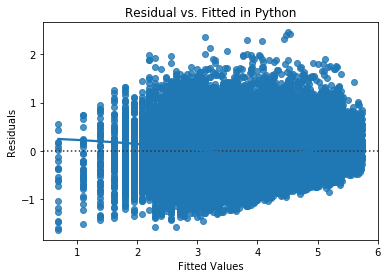

In [11]:
#Residul plot 
sns.residplot(new_data['log_pm25'], model_fit.resid, lowess=True)
plt.title("Residual vs. Fitted in Python")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

RMSE = np.sqrt(metrics.mean_squared_error(new_data['log_pm25'], model_fit.fittedvalues))
print 'The RMSE of the mixed effects model is %.2f' %RMSE

Looks like the model is good fit, since the fitted values a quite randomly distributed around the residual line and the error is very close to 0.

